# Reference
The informations included in this notebook are based on book: *Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on 5 October 2023.*

# Notebook configuration

In [1]:
import matplotlib.pyplot as plt #basic plotting
import plotly.express as px #interactive plots
import seaborn as sns #visualisation of multidimensional data
import pandas as pd
import numpy as np

plt.style.use("seaborn-v0_8")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load data
* **gwl** - groundwater levels for two measurement stations acquired weekly.
* **era** - ERA5 data averaged over area of catchment including the two GWL measurement stations. Dataframe includes following columns: **e** (evaporation), **ro** (runoff), **smlt** (snowmelt), **tp** (precipitation).

Note that data has been previously cleaned (filled gaps, resampled to common frequency).

In [8]:
# read csv, convert strings to dates, set index to date, and assure weekly frequency
gwl = pd.read_csv("https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/gwl.csv", parse_dates=True, index_col=0).asfreq('W-SUN')
era = pd.read_csv("https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/era.csv", parse_dates=True, index_col=0).asfreq('W-SUN')
display(gwl.head())
display(px.line(gwl, title="Groundwater level"))
display(era.head())
display(px.line(era, title="ERA5"))

,II/297/1,II/292/1
date,,
2001-11-11,5.1,12.07
2001-11-18,5.2,12.05
2001-11-25,5.2,12.08
2001-12-02,5.0,12.07
2001-12-09,5.0,12.08


d:\Radek\Doktorat\Inne\waterline-time-series-forecasting\.venv\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



,e,ro,smlt,tp
date,,,,
1999-01-03,-0.000627,0.001155,-4.190952e-09,0.000211
1999-01-10,-0.002396,0.002856,3.344763e-05,0.007754
1999-01-17,-0.003571,0.002986,2.602911e-03,0.012079
1999-01-24,-0.001232,0.002966,1.346360e-05,0.001516
1999-01-31,-0.001778,0.003093,8.748646e-06,0.014691


d:\Radek\Doktorat\Inne\waterline-time-series-forecasting\.venv\Lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



# Exploratory Data Analysis

### Time series features

* **Stationarity** - property of time series data where key statistical characteristics (like mean and variance) remain constant over time. Many statistical forecasting models (eg. ARIMA) assume time series stationarity. **Augmented Dickey-Fuller (ADF)** test is a statistical test used to check if a time series is stationary. If the test statistic is smaller than the critical value (usually 0.05), the data is considered stationary.
* **Autocorrelation** - can be visualized with plot of a correlation of a time series between its different lags. Usefull for selecting Moving Average order in ARIMA model.
* **Partial autocorrelation** - visualized with plot similar to autocorrelation but it tries to nullify effects of other order correlations. In this method Ordinary Least Squares regression is used to fit a time series to its lags. Fitted coefficients are used to calculate the impact of given lag for time series value.
* **Decomposition** - break down of a time series into its constituent components, which typically include trend, seasonality and noise (residuals). In classical decomposition trend is extracted using moving average, sesonaility is average of the detrended values for given season. For example, with monthly data, the seasonal component for March is the average of all the detrended March values in the data. The remainder component is calculated by subtracting the estimated seasonal and trend-cycle components (for additive decomposition). Multiplicative decomposition is also used. Classical decomposition has several shortcomming as its seasonal component can not change over time, moving average does not allow to estimate trend for few samples at the begining and end of time series and is not resilient for single occurences of raping changes of time series. A more versatile and robust method for decomposing time series is **STL (Seasonal and Trend decomposition using Loess)**. The strength of the trend and seasonality relative to residuals affects the forecasting capabilities of a given time course. You can quantitatively estimate the Strength of Trend metric:$$F_T = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(T_t+R_t)}\right),$$
and Strength of Seasonality metric:$$F_S = \max\left(0, 1 - \frac{\text{Var}(R_t)}{\text{Var}(S_{t}+R_t)}\right),$$
where $T_t, S_{t}, R_t$ are trend, seasonal and residual components.
* **Periodogram** - graph that visualize and estimate the dominant frequencies or periodic components in a time series. Calculated using Fast Fourier Transform. Useful in finding the period and strength of seasonality.

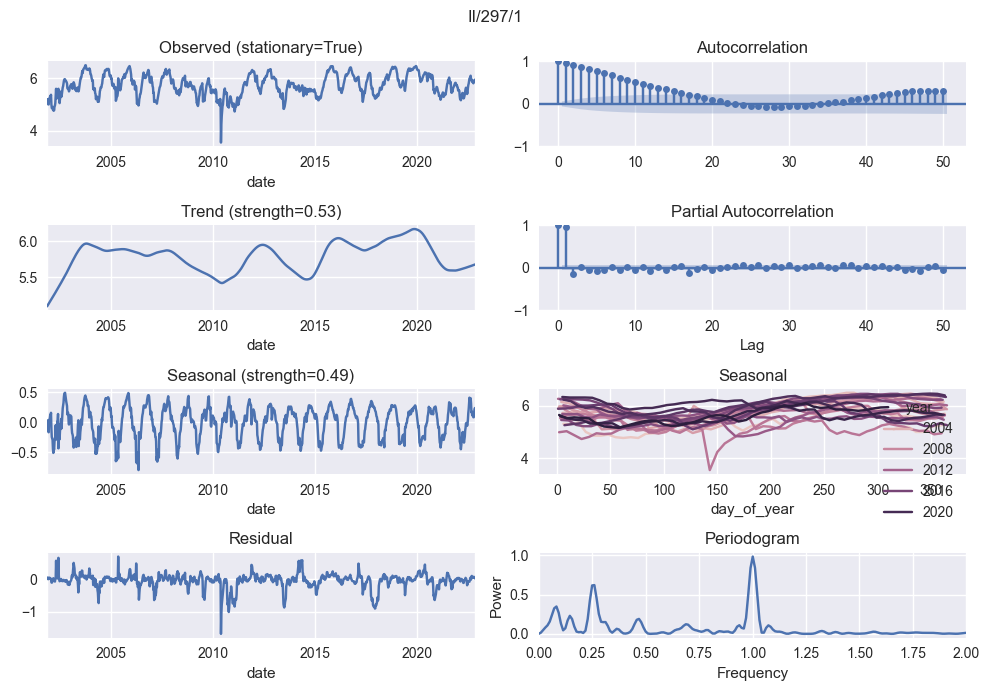

---------------------------------------------------------


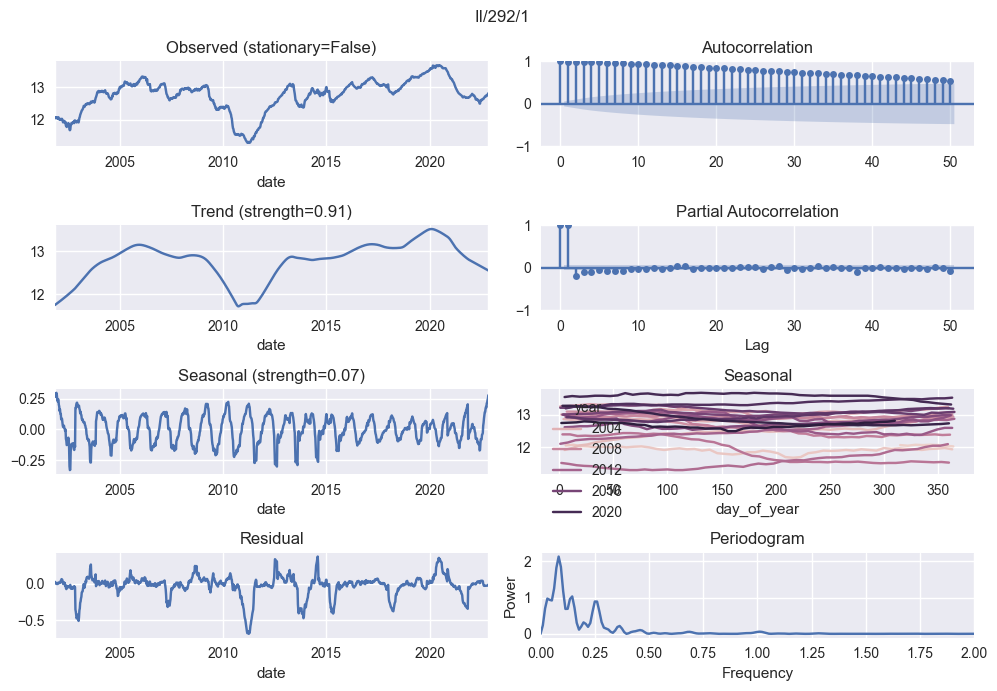

---------------------------------------------------------


In [4]:
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

for c in gwl.columns:
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 7))
    fig.suptitle(c)
    # Stationarity test
    is_stationary = adfuller(gwl[c].dropna())[1] < 0.05
    # STL decomposition
    res = STL(gwl[c].dropna(), period=52, robust=True).fit()
    seasonal_strength = max(0,1 - res.resid.var() / (res.seasonal+res.resid).var())
    trend_strength = max(0,1 - res.resid.var() / (res.trend+res.resid).var())
    res.observed.plot(ax=ax[0,0])
    ax[0,0].set_title(f"Observed (stationary={is_stationary})")
    res.trend.plot(ax=ax[1,0])
    ax[1,0].set_title(f"Trend (strength={trend_strength:.2f})")
    res.seasonal.plot(ax=ax[2,0])
    ax[2,0].set_title(f"Seasonal (strength={seasonal_strength:.2f})")
    res.resid.plot(ax=ax[3,0])
    ax[3,0].set_title("Residual")
    # Autocorrelation
    plot_acf(gwl[c].dropna().values, lags=50, ax=ax[0,1])
    # Partial autocorrelation
    plot_pacf(gwl[c].dropna().values, lags=50, ax=ax[1,1])
    ax[1,1].set_xlabel("Lag")
    # Seasonal plot
    tmp_df = gwl[[c]].copy()
    tmp_df["day_of_year"] = tmp_df.index.dayofyear
    tmp_df["year"] = tmp_df.index.year
    sns.lineplot(x = tmp_df["day_of_year"], y = tmp_df[c], hue=tmp_df["year"], color="black", ax=ax[2,1])
    ax[2,1].set_title("Seasonal")
    ax[2,1].set_ylabel(None)
    # Periodogram
    f, p = periodogram(gwl[c].dropna(), fs=1/(7/365), nfft=5000)
    ax[3,1].plot(f, p)
    ax[3,1].set_title("Periodogram")
    ax[3,1].set_xlim([0, 2])
    ax[3,1].set_xlabel("Frequency")
    ax[3,1].set_ylabel("Power")

    fig.tight_layout()
    plt.show()
    print("---------------------------------------------------------")

# Modelling

**Workflow**
1. Fitting model using lagged era data and known previous time step value of ground water level as input features.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/1_training.png" alt="drawing" width="1000"/>

2. Iteratively building a test prediction using lagged era data and predicted in previous iteration value of ground water level as input fetures.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/2_iterative_test.gif" alt="drawing" width="1000"/>

3. Analogous multiple iterative predictions in train dataset in order to calculate standard deviation of residuals for each step of forecast horizon.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/3_train_horizon.gif" alt="drawing" width="1000"/>

4. 95% confidence interval as 1.96*STD obtained in iterative predictions in train dataset.

<img src="https://raw.githubusercontent.com/radekszostak/waterline-time-series-forecasting/main/media/4_confidence_interval.png" alt="drawing" width="1000"/>

100%|██████████| 45/45 [00:08<00:00,  5.52it/s]


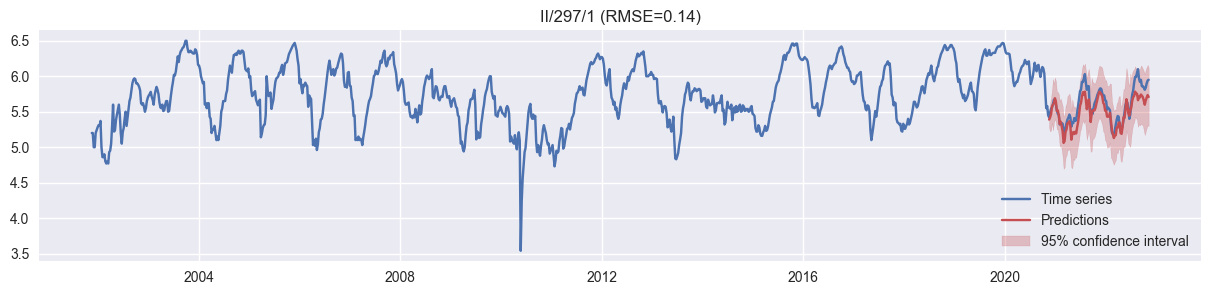

100%|██████████| 45/45 [00:08<00:00,  5.49it/s]


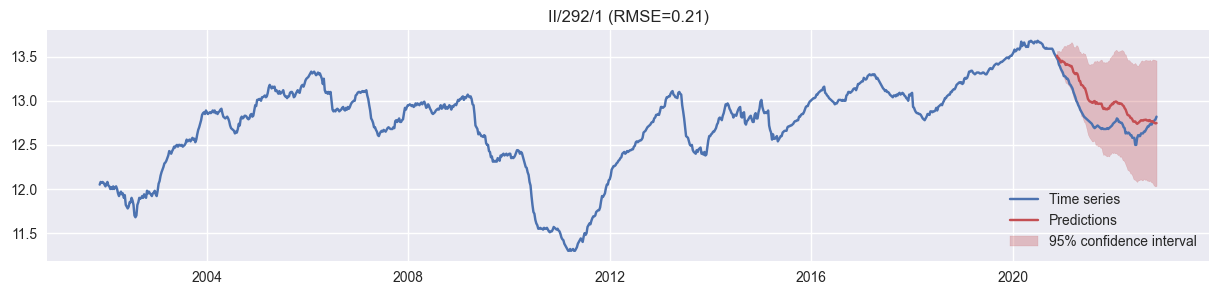

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
for station in gwl.columns:
    forecast_horizon = 52*2 # 104 weeks = 2 years
    station_gwl = gwl[station].rename("gwl")
    # dataset with lagged features
    era_lags_vals = []
    for date, value in station_gwl.items():
        era_lags_vals.append(era.loc[date - pd.Timedelta(weeks=51):date].sort_index(ascending=False).values.flatten())
    era_lags_vals = np.array(era_lags_vals)
    era_lags_cols = [f"{col}-{lag}" for lag in range(52) for col in era.columns]
    era_lags_df = pd.DataFrame(era_lags_vals, columns=era_lags_cols, index=station_gwl.index)
    prev_y = station_gwl.shift(1).dropna().rename("y-1")
    curr_y = station_gwl.loc[prev_y.index].rename("y-0")
    dataset = pd.concat([era_lags_df.loc[prev_y.index], prev_y, curr_y], axis=1)
    train_dataset = dataset.iloc[:-forecast_horizon]
    test_dataset = dataset.iloc[-forecast_horizon:]
    
    # training
    x_train = train_dataset.drop("y-0", axis=1)
    y_train = train_dataset[["y-0"]]
    x_scaler = StandardScaler().fit(x_train)
    y_scaler = StandardScaler().fit(y_train)
    model = Ridge()
    model.fit(x_scaler.transform(x_train), y_scaler.transform(y_train))
    
    # uncertainty
    n_samples = len(x_train)-forecast_horizon
    true_ys = []
    pred_ys = []
    pred_steps = []
    dates = []
    subsets = []
    for i in tqdm(range(0,n_samples, 20)):
        x_train_subset = x_train.iloc[i:i+forecast_horizon]
        y_train_subset = y_train.iloc[i:i+forecast_horizon]
        prev_y = x_train_subset["y-1"].values[0]
        for j in range(forecast_horizon):
            x_train_row = x_train_subset.iloc[j:j+1].copy()
            x_train_row["y-1"] = prev_y
            y_pred = y_scaler.inverse_transform(model.predict(x_scaler.transform(x_train_row))).item()
            prev_y = y_pred
            true_ys.append(y_train_subset.iloc[j].item())
            pred_ys.append(y_pred)
            pred_steps.append(j)
            subsets.append(i)
            dates.append(y_train_subset.index[j])
    uncertainty_df = pd.DataFrame({"true_y": true_ys, "pred_y": pred_ys, "pred_step": pred_steps, "subset": subsets, "date": dates})
    uncertainty_df["residuals"] = uncertainty_df["true_y"] - uncertainty_df["pred_y"]
    uncertainties = uncertainty_df.groupby("pred_step")["residuals"].std()*1.96
    
    # testing
    x_test = test_dataset.drop("y-0", axis=1)
    y_test = test_dataset[["y-0"]]
    prev_y = test_dataset["y-1"].values[0]
    predictions = []
    for i in range(forecast_horizon):
        x_test_row = x_test.iloc[i:i+1].copy()
        x_test_row["y-1"] = prev_y
        y_pred = y_scaler.inverse_transform(model.predict(x_scaler.transform(x_test_row))).item()
        prev_y = y_pred
        predictions.append(y_pred)
    
    rmse = np.sqrt(np.mean((y_test.values.squeeze() - predictions)**2))
    
    plt.figure(figsize=(15,3))
    plt.plot(dataset.index, dataset["y-0"], label="Time series", color=colors[0])
    plt.plot(test_dataset.index, predictions, label="Predictions", color=colors[2])
    plt.fill_between(test_dataset.index, predictions-uncertainties, predictions+uncertainties, alpha=0.3, label="95% confidence interval", color=colors[2])
    plt.title(f"{station} (RMSE={rmse:.2f})")
    plt.legend(loc="lower right")
    plt.show()